These codes calculate and build NDVI time series of each pixel using HLS (Harmonized Landsat and Sentinel-2) dataset. The NDVI time series are then used to classify landcovers. This is an example of using 2017 data on the study area Old Woman Creek (OWC) wetland (longitude: -82° 30’ 3”, Latitude: 41° 22’ 39”). The whole year data of HLS was clipped to OWC extent, and tree bands (red, near infrared and QA) were extracted. In 2017, there were four main land-cover types: 1) open water, 2) Nymphaea odorata (water lily hereafter), 3) Nelumbo lutea (Nelumbo hereafter) and 4) Typha spp. (Typha hereafter). 

Import libraries

In [2]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import copy
import math
import gdal

Calculalte ndvi and filter clouds. The data used here only has three bands extracted from the original HLS data. Band 1 is red, band 2 is NIR and band 3 is QA band.

In [10]:

ndvi = []
fname = []
directory = r'\clip'
cloud_temp = np.empty([50,30], dtype = int)
cloud_code = []
QA_all = []

directory_QA = r'clip'
for filename in os.listdir(directory_QA):
    if filename.endswith(".tif"):
        fp = os.path.join(directory_QA, filename)
        raster_temp = rasterio.open(fp)
        red_temp = raster_temp.read(1)
        nir_temp = raster_temp.read(2)
        QA = raster_temp.read(3)
        if np.all(QA == -9999):
            continue
        else:           
            for m in range (0,50):
                for n in range (0,30):
                    if QA[m][n] == -9999:
                        cloud_temp[m][n] =-9999
                    else:
                        cloud_temp[m][n] = bin(QA[m][n])[-2]
            cloud_copy = copy.copy(cloud_temp)          
            cloud_code.append(cloud_copy)
            cloud_index = np.argwhere(cloud_copy == 1)
           
            ndvi_temp = np.empty(raster_temp.shape, dtype=rasterio.float32)
            check = np.logical_and ( red_temp > 0, nir_temp > 0)
            ndvi_temp = np.where(check,(nir_temp - red_temp ) / ( nir_temp + red_temp ),np.nan)
            ndvi_temp[cloud_index] = np.nan
            ndvi.append(ndvi_temp)
            name_temp = filename[23:26]
            name_copy = copy.copy(name_temp)  
            fname.append(name_copy)
    else:
        continue
#get day of year
ndvi_doy = []
for fname in fname:
    ndvi_doy.append(int(fname))

Plot all the ndvi images

22


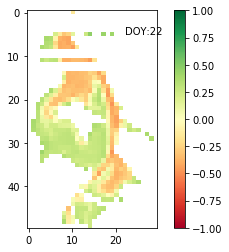

102


<Figure size 432x288 with 0 Axes>

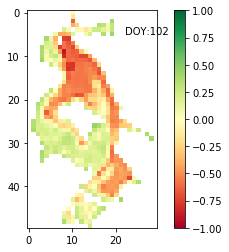

150


<Figure size 432x288 with 0 Axes>

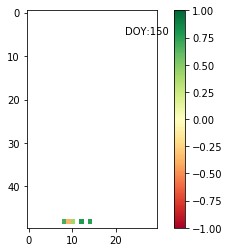

198


<Figure size 432x288 with 0 Axes>

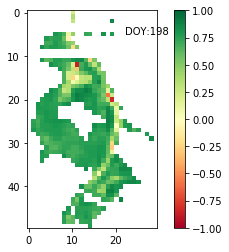

214


<Figure size 432x288 with 0 Axes>

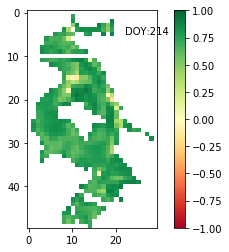

342


<Figure size 432x288 with 0 Axes>

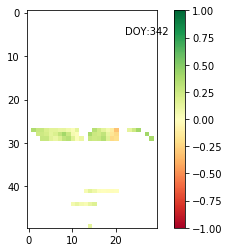

45


<Figure size 432x288 with 0 Axes>

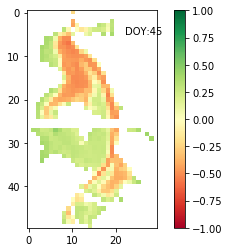

55


<Figure size 432x288 with 0 Axes>

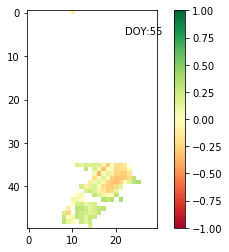

75


<Figure size 432x288 with 0 Axes>

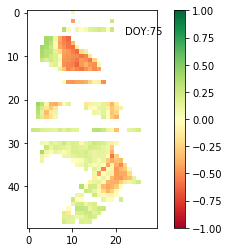

95


<Figure size 432x288 with 0 Axes>

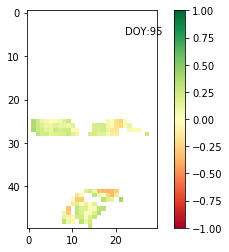

135


<Figure size 432x288 with 0 Axes>

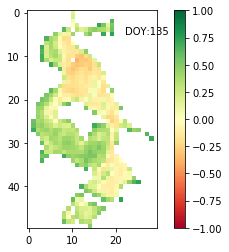

175


<Figure size 432x288 with 0 Axes>

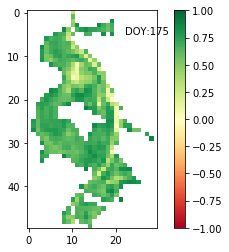

190


<Figure size 432x288 with 0 Axes>

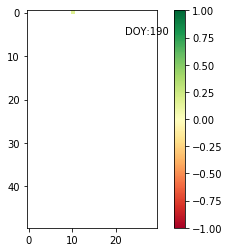

210


<Figure size 432x288 with 0 Axes>

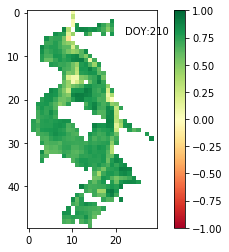

230


<Figure size 432x288 with 0 Axes>

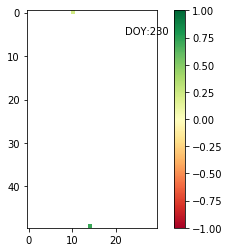

255


<Figure size 432x288 with 0 Axes>

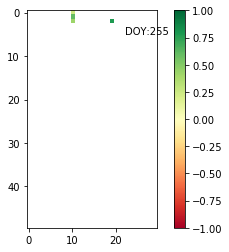

270


<Figure size 432x288 with 0 Axes>

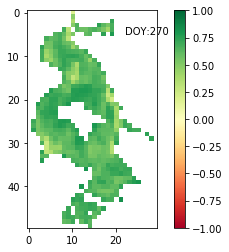

295


<Figure size 432x288 with 0 Axes>

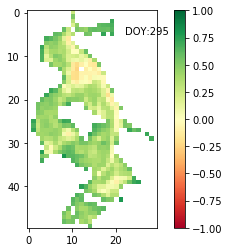

330


<Figure size 432x288 with 0 Axes>

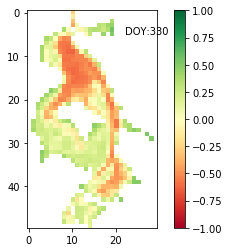

335


<Figure size 432x288 with 0 Axes>

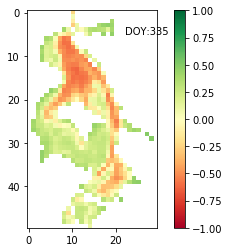

<Figure size 432x288 with 0 Axes>

In [11]:
my_cmap = matplotlib.cm.get_cmap('RdYlGn')
my_cmap.set_under('w')
fig = plt.figure()
for i in range(0,len(ndvi_doy)):
    if np.all(np.isnan(ndvi[i])):
        continue
    else:
        print(ndvi_doy[i])
        plt.figure(i)
        plt.imshow(ndvi[i], my_cmap, vmin = -1, vmax = 1)
        plt.colorbar()
        plt.text(22,5,'DOY:' + str(ndvi_doy[i]), fontsize=10)
        plt.pause(0.6)
        plt.show()
        plt.clf()
        #plt.savefig(str(i))

Keep only growing season NDVI images for classification

In [12]:
ndays = len(ndvi_doy)
nrows = 50
ncols = 30
ndvi_pixel = np.empty([1500,ndays])
for m in range (0,nrows):
    for n in range (0,ncols):        
        for i in range(0,ndays):
            pixel_row = m*30+n
            ndvi_pixel[pixel_row][i] = ndvi[i][m][n]
ndvi_pixel1=np.vstack((np.array(ndvi_doy),np.array(ndvi_pixel)))
ndvi_pixel2=sorted(np.transpose(ndvi_pixel1),key=lambda x:x[0])
ndvi_pixel3=[]
n_pixels_wi_nan=len(ndvi_pixel2)
for i in range(0,n_pixels_wi_nan):
    if ndvi_pixel2[i][0]>134 and ndvi_pixel2[i][0]<296:
        ndvi_pixel3.append(ndvi_pixel2[i][:])
ndvi_sorted=np.transpose(np.array(ndvi_pixel3))[1::]
ndvi_doy_sorted=np.transpose(np.array(ndvi_pixel3))[0:1]

# exclude nans and put each image as a column, each row is ndvi time series of one pixel            
nan_index = []
ndvi_index = []
ndays_growing=np.size(ndvi_doy_sorted,1)
ndvi_owc = np.empty([541,ndays_growing])
count = 0
for i in range (1, 1500):
    if np.all(np.isnan(ndvi_sorted[i][:])):
        nan_index.append(i)
    else:
        ndvi_owc[count] = ndvi_sorted[i][:]
        ndvi_index.append(i)
        count = count+1
        continue

Interpolate each pixel's NDVI time series using linear interpolation

In [13]:
n_pixels=len(ndvi_owc)
ndvi_owc_update = ndvi_owc
#interpolation
ndvi_interp = np.empty([n_pixels,ndays_growing])
#ndvi_interp_list = []
for i in range(0,n_pixels):
    ndvi_temp = pd.DataFrame(ndvi_owc_update[i,:])
    ndvi_interp_temp = ndvi_temp.interpolate(method='linear', limit_direction='both', axis=0)
    ndvi_interp[i,:] = np.transpose(ndvi_interp_temp)

Select pixels to construct standard NDVI time series by referencing WorldView-3 imagery.

In [14]:
ndvi_sorted[:,12]=np.nan #outliers removed mannually
#construct of standard ndvi time seris for each class
water_selected=np.array([np.array([ndvi_sorted[770][:]]),np.array([ndvi_sorted[371][:]]),np.array([ndvi_sorted[680][:]]),np.array([ndvi_sorted[919][:]]),np.array([ndvi_sorted[949][:]])]);
water_st=np.zeros(ndays_growing)
for i in range(0,ndays_growing):
    water_st[i]=np.nanmean(water_selected[:,0,i])
water_interp_st= pd.DataFrame(water_st).interpolate(method='linear', limit_direction='both', axis=0)        
#plt.plot(water_interp_st,'.-b')
#plt.plot(np.transpose(water_st),'.')
#plt.savefig('water_ndvi17')

wl_selected=np.array([np.array([ndvi_sorted[217][:]]),np.array([ndvi_sorted[247][:]]),np.array([ndvi_sorted[873][:]]),np.array([ndvi_sorted[874][:]]),np.array([ndvi_sorted[1363][:]])]);
wl_st=np.zeros(ndays_growing)
for i in range(0,ndays_growing):
    wl_st[i]=np.nanmean(wl_selected[:,0,i])
wl_interp_st= pd.DataFrame(wl_st).interpolate(method='linear', limit_direction='both', axis=0)    
#plt.savefig('wl_ndvi17')

lotus_selected=np.array([np.array([ndvi_sorted[553][:]]),np.array([ndvi_sorted[581][:]]),np.array([ndvi_sorted[768][:]]),np.array([ndvi_sorted[1101][:]]),np.array([ndvi_sorted[1249][:]])]);
lotus_st=np.zeros(ndays_growing)
for i in range(0,ndays_growing):
    lotus_st[i]=np.nanmean(lotus_selected[:,0,i])
lotus_interp_st= pd.DataFrame(lotus_st).interpolate(method='linear', limit_direction='both', axis=0)    
#plt.savefig('lotus_ndvi17')

cattail_selected=np.array([np.array([ndvi_sorted[245][:]]),np.array([ndvi_sorted[693][:]]),np.array([ndvi_sorted[306][:]]),np.array([ndvi_sorted[575][:]]),np.array([ndvi_sorted[1157][:]])]);
cattail_st=np.zeros(ndays_growing)
for i in range(0,ndays_growing):
    cattail_st[i]=np.nanmean(cattail_selected[:,0,i])
cattail_interp_st= pd.DataFrame(cattail_st).interpolate(method='linear', limit_direction='both', axis=0)    
#plt.savefig('cattail_ndvi17')

C:\Users\ju.116\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
C:\Users\ju.116\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\ju.116\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\ju.116\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [15]:
#save standards to .pkl files
water_interp_st.to_pickle("water.pkl")
wl_interp_st.to_pickle("wl.pkl")
cattail_interp_st.to_pickle("cattail.pkl")
lotus_interp_st.to_pickle("lotus.pkl")
ndvi_doy_sorted=pd.DataFrame(ndvi_doy_sorted)
ndvi_doy_sorted.to_pickle("doy.pkl")

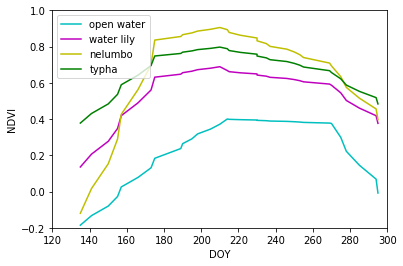

In [16]:
#plot standard ndvi time series for each class
doy=np.transpose(ndvi_doy_sorted)
plt.clf()
plt.plot(np.array(doy),np.array(water_interp_st),'-c',label='open water')
plt.plot(np.array(doy),np.array(wl_interp_st),'-m',label='water lily')
plt.plot(np.array(doy),np.array(lotus_interp_st),'-y',label='nelumbo')
plt.plot(np.array(doy),np.array(cattail_interp_st),'-g',label='typha')
plt.xlabel('DOY')
plt.ylabel('NDVI')
plt.xlim([120,300])
plt.ylim([-0.2,1])
plt.legend(loc="upper left")
plt.savefig('standard ndvi17')

<Figure size 432x288 with 0 Axes>

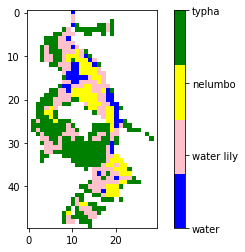

In [17]:
#define dynamic time warping to measure the similarity between standards and each pixel's ndvi time series
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

#calculated the distance by DTW
d1 = np.zeros((541,4))   
ClassNum = np.zeros((541,1))
water_list=water_interp_st.values.tolist()
wl_list=wl_interp_st.values.tolist()
lotus_list=lotus_interp_st.values.tolist()
cattail_list=cattail_interp_st.values.tolist()
for i in range(0,541):
     d1[i][0] = DTWDistance(water_list[:],ndvi_interp[i][:])
     d1[i][1] = DTWDistance(wl_list[:],ndvi_interp[i][:])
     d1[i][2] = DTWDistance(lotus_list[:],ndvi_interp[i][:])
     d1[i][3] = DTWDistance(cattail_list[:],ndvi_interp[i][:])

#assign the class that has the smallest distance as the dominant class of the pixel
for i in range(0,541):
     ClassNum[i] = np.argmin(d1[i][:])
C = ClassNum+1

#add all the nan pixels
Class1D = np.empty((1500,1))
Class1D[:] = np.nan
for i in range(0,541):
    rowNum = ndvi_index[i]
    Class1D[rowNum,:] = C[i]

#### convert 1D array to 2D
Class2D = np.empty([50,30])
Class2D[:] = np.nan
for i in range (0,1500):
    row = np.floor(i/30).astype(int)
    column = np.remainder(i,30)
    Class2D[row][column] = Class1D[i]

#plot the classificaiton result    
plt.clf()    
from matplotlib import colors    
cmap = colors.ListedColormap(['blue','pink','yellow','green'])  
plt.figure()  
plt.imshow(Class2D, cmap)
cbar = plt.colorbar(ticks = [1,2,3,4])
cbar.set_ticklabels(["water","water lily","nelumbo","typha"]) 
#plt.savefig('class2017') 

In [21]:
#save the classification result to tiff
file =r'hls10.tif' #using this image's projection information to save the tiff
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape
#arr_min = arr.min()
#arr_max = arr.max()
#arr_mean = int(arr.mean())
#arr_out = numpy.where((arr < arr_mean), 10000, arr)

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("classification2017.tif", rows, cols, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(Class2D)
outdata.GetRasterBand(1).SetNoDataValue(-9999)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None